# Stochastic optimization methods : ADAM and more 

Authors :
- [Louis DESCHAMPS](https://github.com/louisdeschamps44)
- [Nikola LOHINSKI](https://github.com/NikolaLohinski)

**What you need to know **:
- ADAM method **improves** the weight optimization during **backpropagation** in a neural network
- It is pretty straightforward to implement and **time efficient**
- It can be very **useful with** big neural networks and espacially **big learning sets**
- It **belongs to a bigger set of optimization methods** and each one has its characteristics

<div class="alert alert-info">
In this notebook your will :
<ul>
<li>[🔗](#1-Rendezvous-with-ADAM) Understand what **ADAM** is and discover its **characteristics**</li>
<li>[🔗](#2-And-in-a-neural-network-?) **Implement** it on a simple neural network</li>
<li>[🔗](#3-ADAM-with-Keras) See how to use ADAM within **Keras**</li>
<li>[🔗](#4-Beyond-ADAM-:-AdaGrad,-RMS-Prop-...) Learn **about other stochastic optimization methods** designed for neural networks</li>
<li>[🔗](#5-References) Have some **references** to help you understand everything</li>
</ul>
</div>

<div class="alert alert-warning">
To run this notebook, you will need :
<br>
<ul>
<li>to run on **python $\geq$ 3.5.2**</li>
<li>to have all the requirements listed in '**requirements.txt**' installed. Yo may do that by **running the next cell**. If you encounter any issue, you can try running it in a terminal directly : '**pip install -r requirements.txt**'.</li>
</ul>
</div>



In [ ]:
!pip install -r requirements.txt

Now let's begin with the imports and some configuration :

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import math
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = 12, 9

## 1 Rendezvous with ADAM

### 1.1 Introduction

Neural networks are able to immitate behaviours thanks to backpropagation. The idea is to optimize the weight of each neurone everytime a batch of examples passes through it in order to decrease the prediction error defined by : 

<div class=text-center style="margin-top: 15px">
    $R(\theta) = \sum_{i=1}^{N}{\sum_{k=1}^{K}{(y_k - f_k(x_i))^2}}$
</div>

Where :
* $\theta$ is the vector of weights
* $y_k$ is the output of neurone k
* $f_k(.)$ is the prediction of neurone k
* $x_i$ is the input

To get closer to the minimum of this goal function, we can use the classic gradient descent (SGD) by iterating over :

<div class=text-center style="margin-top: 15px">
    $\theta^{t+1} \simeq \theta^{t} - \gamma_{step} * \nabla_\theta R(\theta^{t})$
</div>    

This way, each increment is defined by the step $\gamma_{step}$ that follows gradient's path (which is $\nabla_\theta R(\theta^{t})$). However, this method has limits :

- the step $\gamma_{step}$ is fixed : the method may never find the actual minimum if the step is not accurately set ;
- the gradient estimation is blindly trusted without taking into account any uncertainty level. If it's evaluation is flawed, then the whole descent is affected ;
- there is no precedency during the descent, therefore no concept of trajectory. It is the same as if a new search was started at every step without knowing anything about the previous one or the one before.

<div class="alert alert-danger" id="question-1">
**Question : **Why are those three limits important to take into account for a neural network ?
</div>
<div class="dropdown">
    
</div>
<div class="alert alert-success">
**Answer : **
<a href="#answer1" data-toggle="collapse" style="text-decoration:none;" title="Show answer"> 👁 </a> _(click on the eye to reveal the answer)_
<ul class="collapse" id="answer1">
    <li>It is useful to use and adpatative step to speed up learning phases. It allows the optimization to be faster when the gradient is pointing constantly in the same direction but slower when getting closer to the minimum to avoid missing it</li>
    <li>Since the gradient may change drastically during the descent, it is interesting to have a feeling of its behaviour in order to know how much it can be trusted. Then only can it be ensured that the weight update is right while keeping the increment in a confidence zone around the gradient's evaluation.</li>
    <li>Keeping track of the trajectory helps to filter out the pertubation noise when performing an update with a batch because it takes into account the history from previous updates and previous batches.</li>
</ul>
</div>

To shed those limits, you will see that ADAM (**Adaptative Moment Estimation**) is a solution through some simple illustrations followed by a dive into the core of the algorithm.

### 1.2 ADAM with a 2D goal function

Let's take a very ugly 2D function ... The _Six-hump camel back_ function :

<div class=text-center>
    $f: (x,y) \longmapsto 4x^{2} - 2.1 x^{4} + \frac{x^{6}}{3} + xy - 4y^{2} + 4x^{4}$
</div>
<div class=text-center>
    $\nabla_{(x,y)} f: (x,y) \longmapsto \left(
    \begin{array}{c}
      8x - 8.4 x^{3} + 2x^{5} + y\\
      x - 8y + 16x^{3}
    \end{array}
  \right)$
</div>

In [3]:
def sixHCB(X):
    """Renvoie l'évaluation en X=(x,y) de la fonction six-hump camel back"""
    return 4 * pow(X[0],2) - 2.1 * pow(X[0],4) + pow(X[0],6)/3 + X[0]*X[1] - 4*pow(X[1],2) + 4*pow(X[1],4)

def grad_sixHCB(X):
    """Renvoie l'évaluation en X=(x,y) du gradient de la fonction six-hump camel back"""
    return np.array([
        8 * X[0] - 8.4 * pow(X[0], 3) + 2 * pow(X[0], 5) + X[1],
        X[0] - 8 * X[1] + 16*pow(X[1],3)
    ])

Let's get a sense of this goal function of 2 independant variables on $[-2, 2]\times[-1, 1]$.

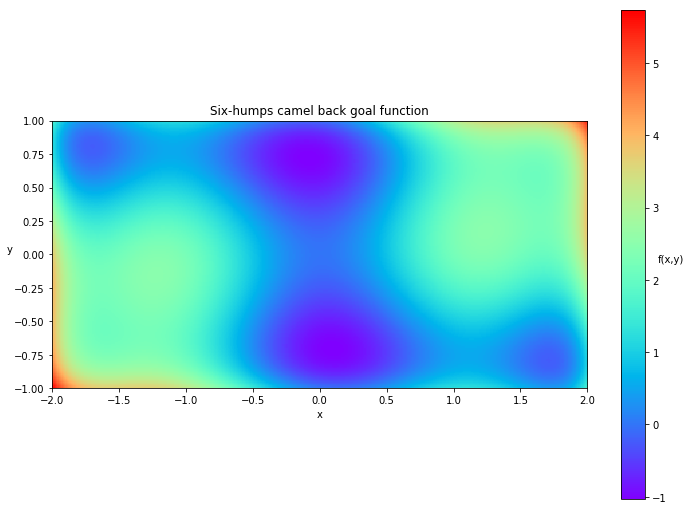

In [4]:
x, y = np.meshgrid(np.arange(-2.,2.,0.01),np.arange(-1.,1.,0.01))
heat_map_points = sixHCB([x,y])
fig, axe = plt.subplots()
pos = axe.imshow(heat_map_points, origin='lower', extent=[-2, 2, -1, 1], cmap=cm.rainbow)
cbar = fig.colorbar(pos, ax=axe)
cbar.ax.set_ylabel('f(x,y)', rotation='horizontal')
plt.ylabel('y', rotation='horizontal')
plt.xlabel('x')
plt.title('Six-humps camel back goal function')
plt.show()

It is now clear that it is an ugly function, with several _cracks_ and _hills_. The closer to red it gets the further it is from the minimum. Let us see how ADAM and the classic gradient descent behave on such a problem.

For a goal precision of 0.0001 and a starting point being [1.2 0. ]:
* The gradient descent succeeded in 15 iterations
* The minimum is [ 1.703605   -0.79608277]

For a goal precision of 0.0001 and a starting point being [1.2 0. ]:
* ADAM descent succeeded in 145 iterations
* The minimum is [ 0.08955223 -0.71242948]



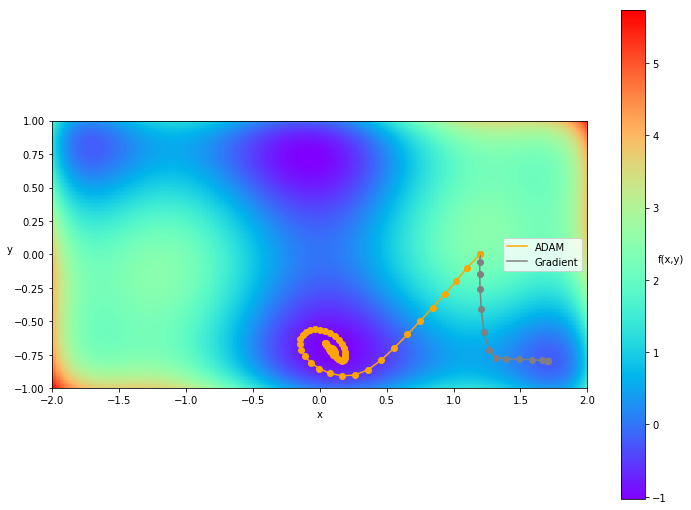

In [5]:
# Mininum of precision to consider the goal reached
precision = 0.0001
# Starting point in [-2,2]x[-1,1]
P0 = np.array([1.2, 0.]) 
# Max iteration fixed in case
MAX_iterations = 10000

################################################################################
# GRADIENT DESCENT
################################################################################
nb_conv = 0
t = 0
gamma = 0.05
grad_path = [P0]
P = np.array(P0)
P_precedent = np.array([math.inf, math.inf])
# Loop until precision is reached
while np.hypot(*(P - P_precedent)) > precision and nb_conv < 10:
    if np.hypot(*(P - P_precedent)) <= precision:
        nb_conv += 1
    else:
        nb_conv = 0
    P_precedent = np.array(P)
    P -= gamma * grad_sixHCB(P)
    grad_path.append(np.array(P))
    t += 1
    # In case the algorithm does not reach the required precision
    if t > MAX_iterations: break
print('For a goal precision of {} and a starting point being {}:'.format(precision, P0))
if t > MAX_iterations:
    print('* The gradient descent did not succeed in {} iterations'.format(MAX_iterations))
else:
    print('* The gradient descent succeeded in {} iterations'.format(t))
    print('* The minimum is {}\n'.format(P))
################################################################################
# ADAM decent
################################################################################
nb_conv = 0
t = 0
alpha = 0.1
m = np.array([0, 0])
beta1 = 0.9
v = np.array([0, 0])
beta2 = 0.999
epsilon = pow(10,-8)
P = np.array(P0)
P_precedent = np.array([math.inf, math.inf]) 
ADAM_path = [P0]
# Loop until precision is reached
while np.hypot(*(P - P_precedent)) > precision and nb_conv < 10:
    if np.hypot(*(P - P_precedent)) <= precision:
        nb_conv += 1
    else:
        nb_conv = 0
    t += 1
    P_precedent = np.array(P)
    m = beta1 * m + (1 - beta1) * grad_sixHCB(P)
    v = beta2 * v + (1 - beta2) * grad_sixHCB(P) * grad_sixHCB(P)
    m_b = m / (1 - pow(beta1,t))
    v_b = v / (1 - pow(beta2,t))
    P -= alpha * m_b / (epsilon + np.power(v_b, 0.5))
    ADAM_path.append(np.array(P))
    if t > MAX_iterations: break
print('For a goal precision of {} and a starting point being {}:'.format(precision, P0))
if t > MAX_iterations:
       print('* ADAM descent did not succeed in {} iterations'.format(MAX_iterations))
else:
    print('* ADAM descent succeeded in {} iterations'.format(t))
    print('* The minimum is {}\n'.format(P))

############################# ILLUSTRATION ################################
fig, axe = plt.subplots()
pos = axe.imshow(heat_map_points, origin='lower', extent=[-2, 2, -1, 1], cmap=cm.rainbow)
cbar = fig.colorbar(pos, ax=axe)
cbar.ax.set_ylabel('f(x,y)', rotation='horizontal')
plt.ylabel('y', rotation='horizontal')
plt.xlabel('x')
plt.scatter([x[0] for x in grad_path],[x[1] for x in grad_path], c='grey')
grad, = plt.plot([x[0] for x in grad_path],[x[1] for x in grad_path], c='grey', label='Gradient')
plt.scatter([x[0] for x in ADAM_path],[x[1] for x in ADAM_path], c='orange')
ADAM, = plt.plot([x[0] for x in ADAM_path],[x[1] for x in ADAM_path], c='orange', label='ADAM')
legend = plt.legend(handles=[ADAM,grad], loc=5)
plt.show()

<div class="alert alert-danger" id="question-2">
**Question : ** What is remarkable about ADAM descent ?
</div>
<div class="dropdown">
    
</div>
<div class="alert alert-success">
**Answer : **
<a href="#answer2" data-toggle="collapse" style="text-decoration:none;" title="Show answer"> 👁 </a> _(click on the eye to reveal the answer)_
<ul class="collapse" id="answer2">
    <li>The increment is always $\Delta \leq 0.1$. This illustrates the confidence on the gradient evaluation and can be modified (it is mostly due to $\alpha = 0.1$) ;</li>
    <li>$\Delta$ decreases when its getting closer to the minimum. The gradient does not vary much more and so does the increment ;</li>
    <li>Finally, we can feel the precedency in the _inertia_ of the descent. It is as the method had a certain velocity and needed to slow down during a sharp bend.</li>
</ul>
</div>

Now that you have a sense of what ADAM does, you can go into the algorithm without getting lost !

<div class="alert alert-info">
**Note : ** the illustration above is convenient only to demonstrate graphically the characteristics of ADAM. However, its behaviour in neural network is different than with a 2D function and leads to better results that the gradient descent which may not be the case in the previous (very) simple example.
</div>

### 1.3 The algorithm


Given a goal function $R$ with a vector parameter $\theta$, the ADAM descent algorithm is :
<div style="background:#F7F7F7;padding:15px;border-radius:3px">
**Require**: $\alpha$ max descent step
<br>
**Require** : $\beta_{1},\beta_{2} \in [0,1)$ exponential decrease rates for moment estimation
<br>
**Require** : $R(\theta)$ a stochastic goal function of a parameter $\theta$
<br>
**Require** : $\theta_{0}$, thi initialization of the parameter $\theta$
<br>
**Require**: $\epsilon$ the correction of the increment
<br>
$ \quad m_0 \longleftarrow \textbf{0}$ (initialize the first moment vector)
<br>
$ \quad v_0 \longleftarrow \textbf{0}$ (initialize the second moment vector)
<br>
$ \quad t \longleftarrow 0$
<br>
$ \quad$**While** $\theta_t$ did not converge, **do**:
<br>
$\quad\quad t \longleftarrow t + 1$
<br>
$\quad\quad g_t \longleftarrow \nabla_\theta R(\theta_{t-1})$
<br>
$\quad\quad m_t \longleftarrow \beta_1 . m_t + (1 - \beta_1) . g_t$
<br>
$\quad\quad v_t \longleftarrow \beta_2 . v_t + (1 - \beta_2) . g_t \odot g_t \quad$ ($\odot$ is the product coordinate by coordinate)
<br>
$\quad\quad \widetilde{m}_t \longleftarrow \frac{m_t}{1 - \beta_{1}^{t}}$
<br>
$\quad\quad \widetilde{v}_t \longleftarrow \frac{v_t}{1 - \beta_{2}^{t}}$
<br>
$\quad\quad \theta_t \longleftarrow \theta_{t-1} - \alpha \frac{\widetilde{m}_t}{(\sqrt{\widetilde{v}_t} + \epsilon)}$
<br>
$\quad$**End while**
<br>
$\quad$**Return** $\theta_t$
</div>

During the computation of the new parameter, there are three important steps :
- **the computation of the moment vectors $m_t$ and $v_t$** : it allows the descent to keep track of history and builds the notion of trajectory :
    - $m_t$ is the first order moment, and can be understood as the mean of the evolution of the goal function around $\theta_{t-1}$. Its value is updated by using **90%** of the previous value and **10%** of the gradient when $\beta_1 = 0.9$
    - $v_t$ is the second order moment, and can be understood as the uncentered standard deviation around $\theta_{t-1}$. It is updated the same way as $m_t$ except for the breakdown which is **99.9%** for the previous value and **0.1%** for the gradient with $\beta_2 = 0.999$
- **the correction of the moment vectors** : this step is very useful during the beginning of the descent, when moment vectors are biaised because initialized with a null value. It allows the algorithm to go faster in the early stage and its effect is exponentially decreased after a few iterations when the moments have grown.
- **The update of the parameter** : the update is similar to the one of the gradient descent, and can be influenced by changing the value of $\alpha$. A simple demonstration can show that the increment (let us call it $|\Delta_t|$) verifies : $|\Delta_t| \leq \alpha$. Therefore, by fixing a value for $\alpha$, we tell the algorithm to create a confidence zone arround $\theta_{t-1}$ in which it can trust the gradient. 

## 2 And in a neural network ?

To be able to implement ADAM by hand, let's take a very simple neural network, with 3 binary inputs, 4 vectors for learning, and a binary output.


In [6]:
# Inputs : 4 vectors 
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# Output : 4 values           
Y = np.array([[0,0,1,1]]).T

Let us define a _NN_ with 3 input neurones, one single neurone for the hidden layer and 1 output neurone to fit the situation.

![Schema](simple_nn.png)

We will use a sigmoid function, therefore we need its definition and its derivative :

In [7]:
# sigmoid function
def sigmoid(x):
    """Renvoie l'évaluation de la fonction sigmoid en x."""
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    """Renvoie l'évaluation de la dérivée de la fonction sigmoid en x."""
    y = 1/(1+np.exp(-x))
    return y*(1-y)

<div class="alert alert-danger">
    **Exercise : ** And now play on, implement ADAM on the this neural network to improve its learning process.
</div>

<div class="alert alert-info">
**Note : **
<ul>
<li> Try not to alter the gradient descent code to be able to compare it to ADAM
<li> We recommend you to use the following default parameters for **ADAM** :
    <div class="text-center" style="margin: 15px 0;">
        $\alpha = 1 \quad \beta_1 = 0.9 \quad \beta_2 = 0.999 \quad \epsilon = 10^{-8}$
    </div>
<li> We encourage you to use _numpy.power(. , .)_ for square root operations in order to be able to do it with vectors directly
</ul>
</div>

f(X) after learning:
- For SGD :
[[0.00679856]
 [0.0055348 ]
 [0.9954867 ]
 [0.99445488]]
- For ADAM :
[[1.86647557e-04]
 [1.48244021e-04]
 [9.99882241e-01]
 [9.99851733e-01]]


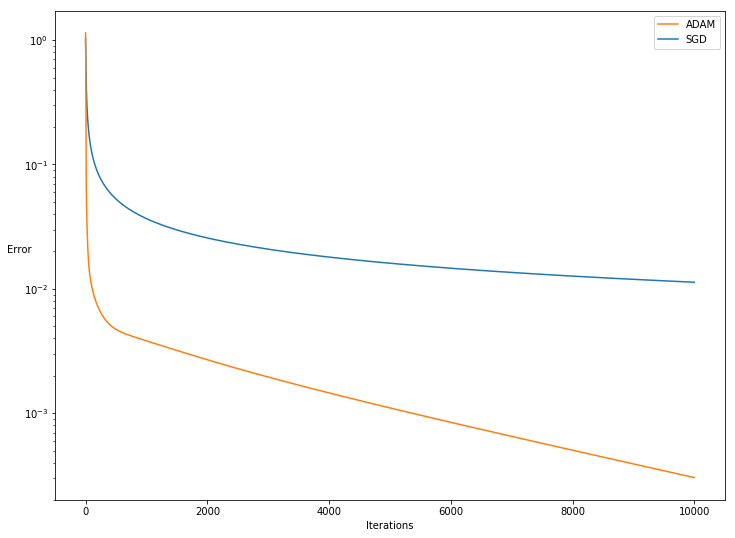

In [8]:
# Random initialization of weights
alpha_grad = 2 * np.random.random((3,1)) - 1
alpha_ADAM = 2 * np.random.random((3,1)) - 1

# Number of iterations over dataset
nb_steps = 10000

# Error evolution
error_grad = np.zeros(nb_steps)
error_ADAM = np.zeros(nb_steps)

# Parameters for gradient descent
gamma = 1

# Parameters for ADAM
a = 1
beta1 = 0.9
beta2 = 0.999
epsilon = pow(10, -8)
m = np.zeros(alpha_ADAM.shape)
v = np.zeros(alpha_ADAM.shape)

for t in range(nb_steps):

    # Gradient descent
    X_grad = np.dot(X,alpha_grad)
    f_X_grad = sigmoid(X_grad)
    error_grad[t] = np.linalg.norm(Y - f_X_grad)
    delta = -2 * (Y - f_X_grad) * 1 
    s = sigmoid_der(X_grad) * 1 * delta 
    alpha_grad -= gamma * np.dot(X.T, s)
    ############################################################################
    # Here comes your code
    # ADAM
    X_ADAM = np.dot(X,alpha_ADAM)
    f_X_ADAM = sigmoid(X_ADAM)
    error_ADAM[t] = np.linalg.norm(Y - f_X_ADAM)
    delta = -2 * (Y - f_X_ADAM) * 1 
    s = sigmoid_der(X_ADAM) * 1 * delta 
    # Up to here it is exactly like the gradient descent
    g = np.dot(X.T, s)
    # First moment vector
    m = beta1 * m + (1 - beta1) * g
    # Second moment vector
    v = beta2 * v + (1 - beta2) * g * g
    # Moment vector correction
    m_b = m / (1 - pow(beta1, t + 1))
    v_b = v / (1 - pow(beta2, t + 1))
    # Parameter update
    alpha_ADAM -= a * m_b / (np.power(v_b, 0.5) + epsilon)
    ############################################################################
print("f(X) after learning:")
print("- For SGD :\n{}".format(f_X_grad))
grad, = plt.plot(error_grad, label="SGD")

print("- For ADAM :\n{}".format(f_X_ADAM))
ADAM, = plt.plot(error_ADAM, label="ADAM")

legend = plt.legend(handles=[ADAM,grad], loc=1)
plt.yscale('log')
plt.ylabel('Error', rotation='horizontal')
plt.xlabel('Iterations')
plt.show()

## 3 ADAM with Keras

The **high-level API Keras** is built on top of **Tensorflow** and was conceived to make deep neural network prototyping relatively easy and fast. It comes with several out-of-the-box tools among whom one can find the **optimizers**. **ADAM** is one of them.

To illustrate how ADAM behaves on a more complex problem wiht Keras, we will use the a dataset for letter detection build with 20 different fonts. Therefore, we have 26 classes determining the 26 letters of the alphabet. To be able to detect them and classify letters, we will use 16 numeric features suggested by David J. Slate on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition). The dataset has 20 000 example and we will use 16 000 for training and 4 000 for testing.

With a simple neural network, we will compare de gradient descent to ADAM by keeping all the other parameters (depth of the network, activation functions, loss function etc...) unchanged. The goal is to highlight that it is possible to drastically improve performances just by changing the optimizer.

In [9]:
# Load data
param = 16 # Number of parameters
dataset = np.loadtxt("dataset.csv", delimiter=",")

# Inputs
X = dataset[:,1:param+1]
# Outputs
Y = dataset[:,0]

# The classs needs to be indicated by a 0 or a 1 on a vector, therefore we
# map 1 to [1 0 0 ... 0], 2 to [0 1 0 ... 0] ... and 26 to [0 0 0 ... 0 1]
from keras.utils import to_categorical
y= to_categorical(Y)
y=y[:,1:27]

# Divide training and testing sets
X_train = X[0:15999, :]
Y_train = y[0:15999, :]
X_test = X[16000:, :]
Y_test = y[16000:, :]

In [10]:
# Re-initialize numpy's random seed
np.random.seed(1)

# Model :
# - layer 1 : 100 neurones
# - layer 2 : hidden layer, 50 neurones
# - layer 3 : output layer, 26 neurones for 26 letters
model = Sequential()
model.add(Dense(100, input_dim=param, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(26, activation='softmax'))


# Compilation with gradient descent for starters
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=[keras.metrics.categorical_accuracy])

# Fitting
history_classic = model.fit(X_train, Y_train, epochs=50, batch_size=100)

Epoch 1/50
15999/15999 [==============================] - 1s 70us/step - loss: 2.9071 - categorical_accuracy: 0.1863
Epoch 2/50
15999/15999 [==============================] - 0s 20us/step - loss: 2.0820 - categorical_accuracy: 0.4583
Epoch 3/50
15999/15999 [==============================] - 0s 19us/step - loss: 1.6240 - categorical_accuracy: 0.5796
Epoch 4/50
15999/15999 [==============================] - 0s 20us/step - loss: 1.3769 - categorical_accuracy: 0.6400
Epoch 5/50
15999/15999 [==============================] - 0s 21us/step - loss: 1.2416 - categorical_accuracy: 0.6673
Epoch 6/50
15999/15999 [==============================] - 0s 21us/step - loss: 1.1512 - categorical_accuracy: 0.6896
Epoch 7/50
15999/15999 [==============================] - 0s 21us/step - loss: 1.0872 - categorical_accuracy: 0.7060
Epoch 8/50
15999/15999 [==============================] - 0s 21us/step - loss: 1.0384 - categorical_accuracy: 0.7179
Epoch 9/50
15999/15999 [==============================] - 0s 21u

4000/4000 [==============================] - 0s 24us/step

categorical_accuracy: 83.12%


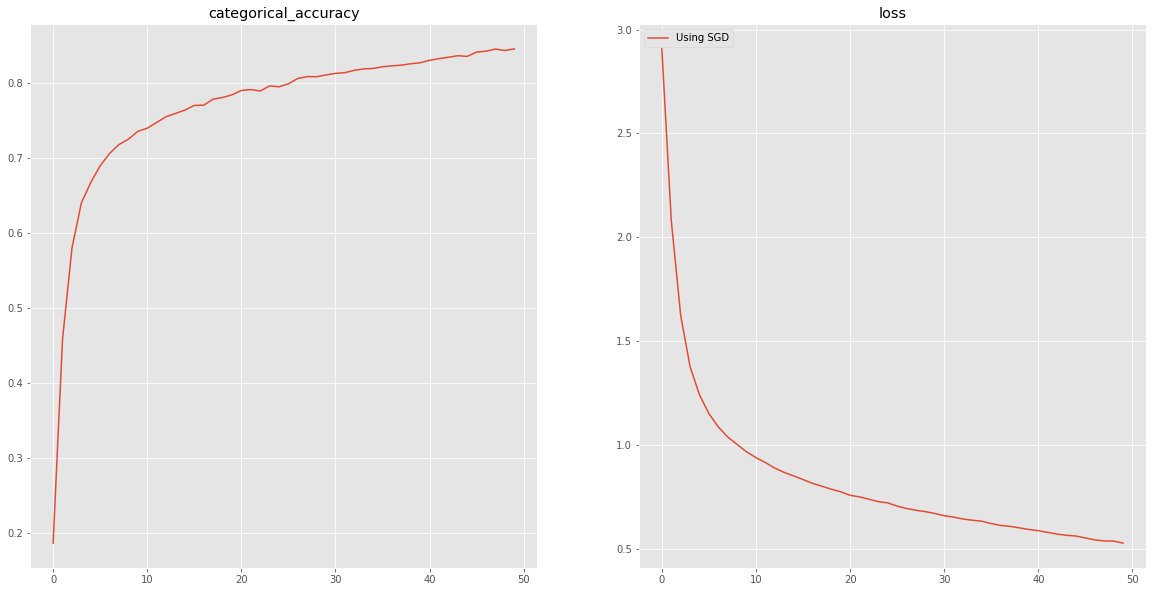

In [11]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
for i, (name, values) in enumerate(history_classic.history.items()):
    plt.subplot(1, len(history_classic.history.items()), i+1)
    gradplot = plt.plot(values, label = "Using SGD")
    plt.title(name)
    
legend = plt.legend(handles=[gradplot[0]], loc=2)
    
# Evaluation
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

<div class="alert alert-danger">
    **Exercise : ** And now play on, use ADAM in Keras with the same neural network. Observe and comment results. You may keep default parameters. For documentation on optimizers and how to use them, follow [this link](https://keras.io/optimizers/). 
</div>

In [12]:
# Re-initialize numpy's random seed
np.random.seed(1)

# Model :
# - layer 1 : 100 neurones
# - layer 2 : hidden layer, 50 neurones
# - layer 3 : output layer, 26 neurones for 26 letters
model = Sequential()
model.add(Dense(100, input_dim=param, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(26, activation='softmax'))

############################################################################
# Here comes your code
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=[keras.metrics.categorical_accuracy])
############################################################################

# Fitting
history_adam = model.fit(X_train, Y_train, epochs=50, batch_size=100)

Epoch 1/50
15999/15999 [==============================] - 1s 34us/step - loss: 2.5178 - categorical_accuracy: 0.3160
Epoch 2/50
15999/15999 [==============================] - 0s 22us/step - loss: 1.3013 - categorical_accuracy: 0.6580
Epoch 3/50
15999/15999 [==============================] - 0s 21us/step - loss: 1.0274 - categorical_accuracy: 0.7234
Epoch 4/50
15999/15999 [==============================] - 0s 22us/step - loss: 0.8978 - categorical_accuracy: 0.7534
Epoch 5/50
15999/15999 [==============================] - 0s 22us/step - loss: 0.8094 - categorical_accuracy: 0.7773
Epoch 6/50
15999/15999 [==============================] - 0s 20us/step - loss: 0.7383 - categorical_accuracy: 0.7959
Epoch 7/50
15999/15999 [==============================] - 0s 21us/step - loss: 0.6894 - categorical_accuracy: 0.8083
Epoch 8/50
15999/15999 [==============================] - 0s 20us/step - loss: 0.6464 - categorical_accuracy: 0.8167
Epoch 9/50
15999/15999 [==============================] - 0s 20u

4000/4000 [==============================] - 0s 26us/step


/home/nikola/Envs/nno/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



categorical_accuracy: 90.90%


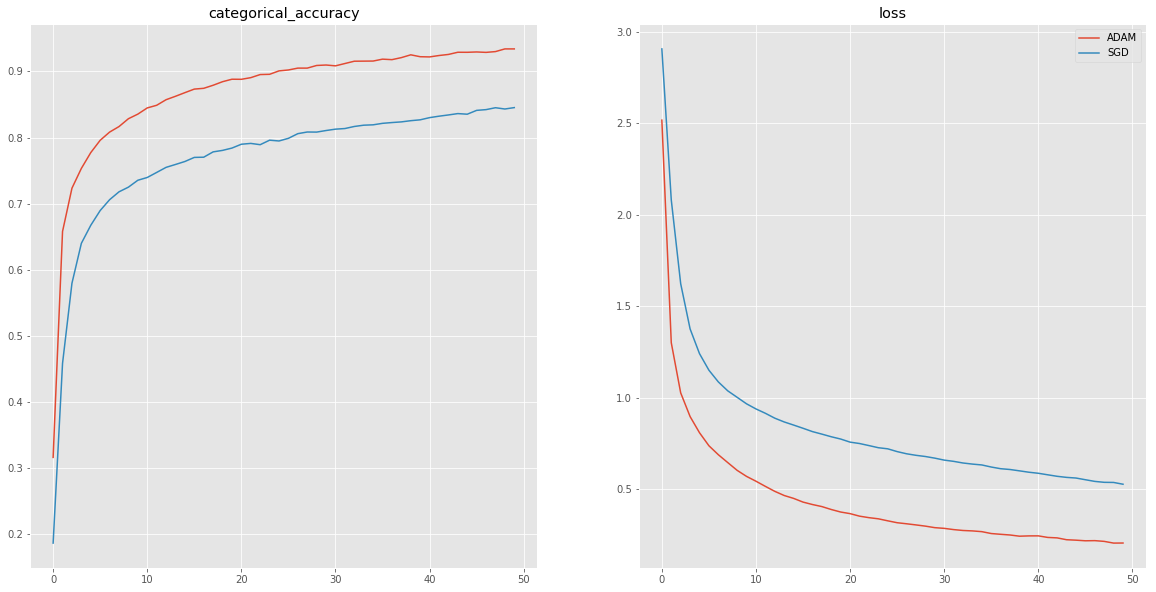

In [13]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
for i, (name, values) in enumerate(history_adam.history.items()):
    plt.subplot(1, len(history_adam.history.items()), i+1)
    adaplot = plt.plot(values, label="ADAM")
    plt.title(name)    
for i, (name, values) in enumerate(history_classic.history.items()):
    plt.subplot(1, len(history_classic.history.items()), i+1)
    gradplot = plt.plot(values, label='SGD')
    plt.title(name)

legend = plt.legend(handles=[adaplot[0], gradplot[0]], loc=0)
    
# Evaluationù
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

<div class="alert alert-success">
**Answer : **
<a href="#answer3" data-toggle="collapse" style="text-decoration:none;" title="Show answer"> 👁 </a> _(click on the eye to reveal the answer)_
<div class="collapse" id="answer3">
This test case shows that ADAM improves the learning curve, and even the score on the testing dataset. With the same computation time, it increases the categoraical accuracy from 81% to 90%, which can be very useful on bigger problems and datasets because it may mean a lot of time saved.
<br><br>
During prototyping, it is important to test other methods for stochastic optimization because it may be a simple way to improve the learning phase, but beware, for some specific problems, **ADAM may be useless** !
</div>
</div>

You are probably saying :
- "This is amazing, are there other methods that may be of help when ADAM is not giving any result ?"
- "We are glad to hear you ask that !"

## 4 Beyond ADAM : AdaGrad, RMS Prop ...

ADAM is one of many alternative gradient descents. Among the most well known :
- AdaGrad
- AdaDelta
- RMS Prop
- AdaMax, a variant of ADAM
- etc...

In [this article](http://ruder.io/optimizing-gradient-descent/index.html) and [this blog](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f), you can find more thourough description of those methods. Some of them are available in Keras, and the way to use them is explained in the [documentation on optimizers](https://keras.io/optimizers/).

<div class="alert alert-danger">
    **Exercise : ** And now play on, try several optimizers on the previous neural network and find the best one. You can keep default parameters not to spend to much time on it but on a real case, you would need to tweak them as well.
</div>
<div class="alert alert-warning">
    ** Caution : ⬇** The next cell may take some time to run and does not display any feedback our output **⬇**
</div>

In [14]:
# Re-initialize numpy's random seed
np.random.seed(1)

# List optmizers
############################################################################
# Here comes your code
optimizers = [
    (keras.optimizers.SGD(), 'SGD'),
    (keras.optimizers.SGD(nesterov=True), 'SGD - Nesterov'),
    (keras.optimizers.Adam(), 'Adam'),
    (keras.optimizers.RMSprop(), 'RMSProp'),
    (keras.optimizers.Adagrad(), 'AdaGrad'),
    (keras.optimizers.Adadelta(), 'AdaDelta'),
    (keras.optimizers.Adamax(), 'AdaMax'),
    (keras.optimizers.Nadam(), 'NAdam')
]
############################################################################

# Model factory for each optimizer
def model_factory(optimizer):
    _model = Sequential()
    _model.add(Dense(100, input_dim=param, activation='relu'))
    _model.add(Dense(50, activation='relu'))
    _model.add(Dense(26, activation='softmax'))
    _model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=optimizer,
        metrics=[keras.metrics.categorical_accuracy]
    )
    return _model

# Create and compile models
models = [
    (model_factory(o[0]), o[1]) for o in optimizers
]

# Keep histories
histories = list(map(
    lambda m: m[0].fit(
        X_train, Y_train, epochs=50, batch_size=100, verbose=0
    ),
    models
))

Categorical accuracy (training and testing):
* SGD :
 84.74% and 83.18%
* SGD - Nesterov :
 85.26% and 84.05%


/home/nikola/Envs/nno/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


* Adam :
 93.88% and 91.88%
* RMSProp :
 94.02% and 92.2%
* AdaGrad :
 87.01% and 84.72%
* AdaDelta :
 94.41% and 91.65%
* AdaMax :
 91.26% and 89.12%
* NAdam :
 95.84% and 92.98%


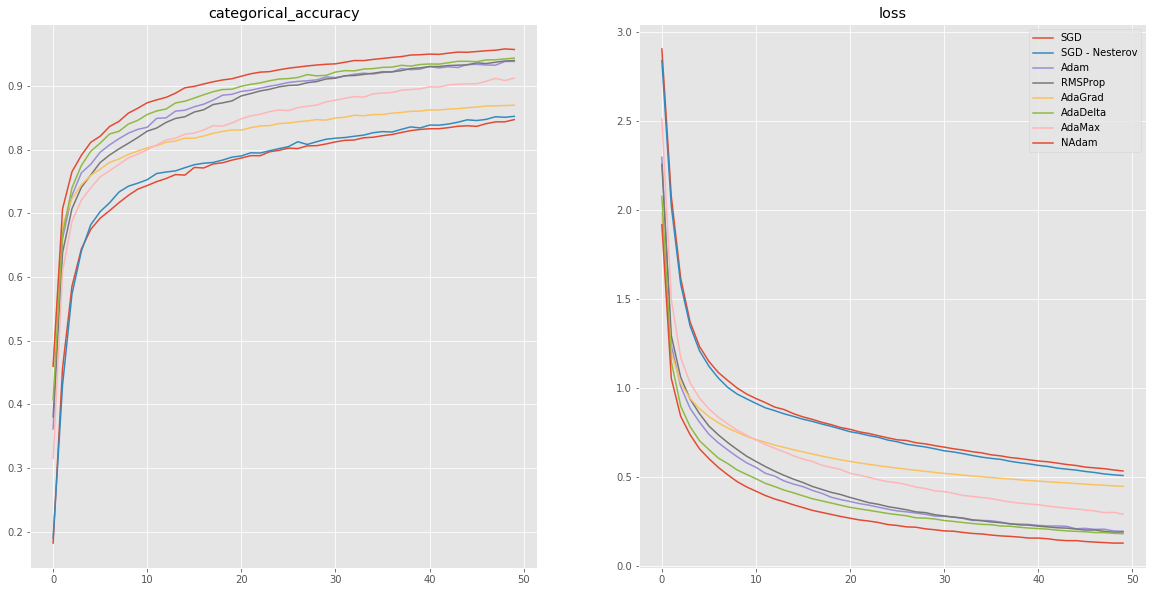

In [15]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
plots = []
print('Categorical accuracy (training and testing):')
for i, history in enumerate(histories):
    model = models[i][0]
    optimizer = models[i][1]
    for i, (name, values) in enumerate(history.history.items()):
        plt.subplot(1, len(history.history.items()), i+1)
        p = plt.plot(values, label=optimizer)[0]
        plt.title(name)
    # Evaluate the model
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('* {} :\n {}% and {}%'.format(
        optimizer,
        round(np.max(history.history['categorical_accuracy']) * 100, 2),
        round(score[1] * 100, 2)
    ))
    plots.append(p)

legend = plt.legend(handles=plots, loc=0)

<div class="alert alert-success">
**Answer : **
<a href="#answer4" data-toggle="collapse" style="text-decoration:none;" title="Show answer"> 👁 </a> _(click on the eye to reveal the answer)_
<div class="collapse" id="answer4">
    Here comes for each method the learning accuracy on the training dataset and the categorical accuracy on the testing dataset :
<ul>
    <li>Classic gradient descent (SGD) : 84.76% and 83.12%</li>
    <li>SGD with Nesterov moment : 84.76% and 83.12%</li>
    <li>ADAM : 94.05% and 91.68%</li>
    <li>RMS Prop : 94.02% and 92.2%</li>
    <li>Adagrad : 87.11% and 84.85%</li>
    <li>Adadelta : 94.26% and 91.42%</li>
    <li>Adamax : 91.16% and 88.82%</li>
    <li>**Nadam : 95.49% and 92.12%**</li>
</ul>

It seems that default parameters on Nadam return the best results for this network ! 
</div>

## 5 References
<ul style="list-style:none; padding: 0;">
<li>[1] [Adam: A Method for Stochastic Optimization - _Diederik P. Kingma, Jimmy Ba_](https://arxiv.org/abs/1412.6980)
<li>[2] [An overview of gradient descent optimization algorithms - Sebastian Ruder](http://ruder.io/optimizing-gradient-descent/index.html#references)
<li>[3] [Types of Optimization Algorithms used in Neural Networks and Ways to Optimize Gradient Descent - Anish Singh Walia](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f)
<li>[4] [Letter Recognition Data Set - _David J. Slate_](https://archive.ics.uci.edu/ml/datasets/Letter+Recognition)
<li>[5] [Keras' documentation on optimizers](https://keras.io/optimizers/)
</ul>